In [25]:
#https://www.kaggle.com/aisatriano/cactuses-for-fastai-resnet34-and-resnet50
#https://www.kaggle.com/nguyncaoduy/aerial-cactus-identification-100-fastai-resnet
#https://www.kaggle.com/adamdavis99/fastai-2-notebook
#https://www.kaggle.com/nguyncaoduy/aerial-cactus-identification-fastai-ensemble
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pathlib import Path
# import fastai.vision as fv
from fastai import *
from fastai.vision.all import *
from fastai.data.all import *
import torch

In [26]:
train_df = pd.read_csv("training_set.csv")
test_df = pd.read_csv("validation_set.csv")

In [ ]:
dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                get_x=ColReader(0, pref=f"train_set/"),
                get_y=ColReader(1),
                splitter=RandomSplitter(),
                item_tfms=Resize(460),
                batch_tfms=[*aug_transforms(size=224,min_scale=0.75),Normalize.from_stats(*imagenet_stats), do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75])

In [37]:
test_db=ImageDataLoaders.from_df(test_df, path="test_set/")

In [38]:
batch_tfms=[*aug_transforms(size=224,min_scale=0.75),Normalize.from_stats(*imagenet_stats)]

In [39]:
dblock.summary(train_df)

Setting-up type transforms pipelines
0        cactus_0028_1.jpg  1     training_set/cactus\cactus_0028_1.jpg
1       cactus_0028_10.jpg  1    training_set/cactus\cactus_0028_10.jpg
2      cactus_0028_101.jpg  1   training_set/cactus\cactus_0028_101.jpg
3      cactus_0028_104.jpg  1   training_set/cactus\cactus_0028_104.jpg
4      cactus_0028_106.jpg  1   training_set/cactus\cactus_0028_106.jpg
5      cactus_0028_107.jpg  1   training_set/cactus\cactus_0028_107.jpg
6      cactus_0028_108.jpg  1   training_set/cactus\cactus_0028_108.jpg
7      cactus_0028_109.jpg  1   training_set/cactus\cactus_0028_109.jpg
8      cactus_0028_110.jpg  1   training_set/cactus\cactus_0028_110.jpg
9      cactus_0028_111.jpg  1   training_set/cactus\cactus_0028_111.jpg
10     cactus_0028_112.jpg  1   training_set/cactus\cactus_0028_112.jpg
11     cactus_0028_113.jpg  1   training_set/cactus\cactus_0028_113.jpg
12     cactus_0028_114.jpg  1   training_set/cactus\cactus_0028_114.jpg
13     cactus_0028_115.jpg 

Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
    starti

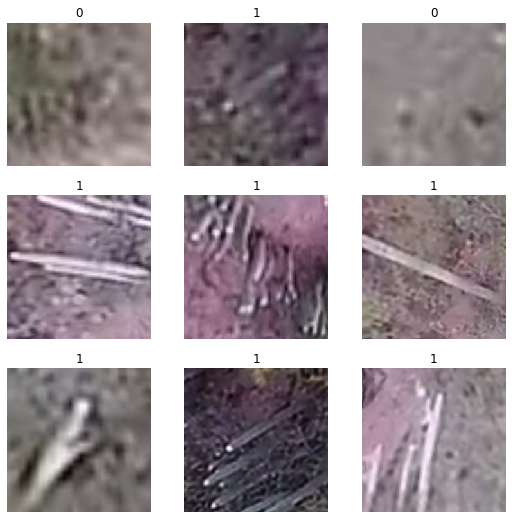

In [41]:
dls=dblock.dataloaders(train_df)
dls.show_batch()

In [42]:
x,y=dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.1217, 0.0091, 0.2940]), TensorImage([0.6265, 0.5902, 0.6534]))

In [45]:
learn=cnn_learner(dls,resnet34,metrics=[error_rate,accuracy])

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time


In [ ]:
learn.lr_find()

In [ ]:
lr=6.309573450380412e-07
learn=learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5,slice(lr))

In [28]:
test_img = ImageList.from_df(test_df, path="./", folder='test_set')
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(train_df, path='./', folder='train_set')
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64)
        .normalize(imagenet_stats)
       )

NameError: name 'ImageList' is not defined

In [ ]:
learn = cnn_learner(train_img, models.densenet161, metrics=[error_rate, accuracy])

In [ ]:
lr = 3e-02
learn.fit_one_cycle(5, slice(lr))

In [ ]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
test_df.has_cactus = preds.numpy()[:, 0]

In [ ]:
test_df.to_csv('submission.csv', index=False)